# <p style="background-color:green; font-family:calibri; font-size:100%; text-align:center"> London bike sharing prediction - Python for DataScience Assignement</p>

# Introduction

Kaggle dataset: [London bike sharing dataset](https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset). 

The data from cycling dataset is grouped by "Start time", this represent the count of new bike shares grouped by hour.

Metadata:
* "timestamp" - timestamp field 
* "cnt" - the count of a new bike shares
* "t1" - real temperature in Celsius
* "t2" - temperature in Celsius "feels like"
* "hum" - humidity in percentage
* "windspeed" - wind speed in km/h  
* "is_holiday" - boolean field - 1 holiday / 0 non holiday
* "is_weekend" - boolean field - 1 if the day is weekend
* "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.
* "weather_code" - category of the weather:
  - 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
  - 2 = scattered clouds / few clouds 
  - 3 = Broken clouds 
  - 4 = Cloudy 
  - 7 = Rain/ light Rain shower/ Light rain 
  - 10 = rain with thunderstorm 
  - 26 = snowfall 
  - 94 = Freezing Fog

**The main goal of this project is to train a model to predict number of rented bikes.** 

Libraries used:
* [FB Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

# Loading dataset

In [42]:
import numpy as np 
import pandas as pd
import os

df = pd.read_csv("./london_merged.csv")
df.head()


timestamp  cnt   t1   t2    hum  wind_speed  weather_code  \
0  2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0           3.0   
1  2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0           1.0   
2  2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0           1.0   
3  2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0           1.0   
4  2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5           1.0   

   is_holiday  is_weekend  season  
0         0.0         1.0     3.0  
1         0.0         1.0     3.0  
2         0.0         1.0     3.0  
3         0.0         1.0     3.0  
4         0.0         1.0     3.0


## Data preprocessing
in this paragraph we perform a series of operations on the data in order to prepare the dataset for subsequent analysis.


In [43]:
import pandas_profiling as pp 

profile = pp.ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In order to quickly perform the analysis we'll be trying out the **ProfileReport()** from **pandas_profiling**.

**pandas_profiling** generates profile reports from a pandas DataFrame, It extends pandas DataFrame with df.profile_report(), which automatically generates a standardized univariate and multivariate report for data understanding.

For each column, the following information (whenever relevant for the column type) is presented in an interactive HTML report:

- Descriptive statistics: mean, mode, standard deviation, sum, median absolute deviation, coefficient of variation, kurtosis, skewness
- Most frequent and extreme values
- Histograms: categorical and numerical
- Correlations: high correlation warnings, based on different correlation metrics (Spearman, Pearson, Kendall, Cramér’s V, Phik, Auto)
- Missing values: through counts, matrix, heatmap and dendrograms
- Duplicate rows: list of the most common duplicated rows

The report contains three additional sections:

- Overview: mostly global details about the dataset (number of records, number of variables, overall missigness and duplicates, memory footprint)
- Alerts: a comprehensive and automatic list of potential data quality issues (high correlation, skewness, uniformity, zeros, missing values, constant values, between others)
- Reproduction: technical details about the analysis (time, version and configuration)

This tool allows us to immediately have a general overview of the data we are going to work with.


### Handling date format

Looking at the **ProfileReport()** seems clear that we have a clean dataset. We noticed that the timestamp column must be converted to **Datetime** in order to be able to work with the date format more easily. Furthermore We're going to set the timestamp column as index column as it contains unique values.

In [44]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")

df.head()

cnt   t1   t2    hum  wind_speed  weather_code  \
timestamp                                                             
2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0           3.0   
2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0           1.0   
2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0           1.0   
2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0           1.0   
2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5           1.0   

                     is_holiday  is_weekend  season  
timestamp                                            
2015-01-04 00:00:00         0.0         1.0     3.0  
2015-01-04 01:00:00         0.0         1.0     3.0  
2015-01-04 02:00:00         0.0         1.0     3.0  
2015-01-04 03:00:00         0.0         1.0     3.0  
2015-01-04 04:00:00         0.0         1.0     3.0

Starting from **timestamp** column we created new features as they may come in handy during exploratory data analysis and predictive model training. 

As can be seen below, we added the following columns:
- hour
- day_of_month: number indicating the number of the day in the month
- day_of_week: number indicating the number of the day in the week (0: Monday, 1: Tuesday, 2: Wednesday, 3: Thursday, 4: Friday, 5: Saturday, 6: Sunday)
- month
- year 
- day_name: string representing the weekday name
 

In [45]:
df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month
df["year"] = df.index.year
df["day_name"] = df.index.day_name()
df.head()

cnt   t1   t2    hum  wind_speed  weather_code  \
timestamp                                                             
2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0           3.0   
2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0           1.0   
2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0           1.0   
2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0           1.0   
2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5           1.0   

                     is_holiday  is_weekend  season  hour  day_of_month  \
timestamp                                                                 
2015-01-04 00:00:00         0.0         1.0     3.0     0             4   
2015-01-04 01:00:00         0.0         1.0     3.0     1             4   
2015-01-04 02:00:00         0.0         1.0     3.0     2             4   
2015-01-04 03:00:00         0.0         1.0     3.0     3             4   
2015-01-04 04:00:00         0.0         1.0     3.0     4             4   

                     day_of_week  month  year day_name  
timestamp                                               
2015-01-04 00:00:00            6      1  2015   Sunday  
2015-01-04 01:00:00            6      1  2015   Sunday  
2015-01-04 02:00:00            6      1  2015   Sunday  
2015-01-04 03:00:00            6      1  2015   Sunday  
2015-01-04 04:00:00            6      1  2015   Sunday

Below we add the season_name column containing the names of the seasons.

In [46]:
# multiple conditions
conditions = [
    (df['season']==0.0),
    (df['season']==1.0),
    (df['season']==2.0),
    (df['season']==3.0),
]

#0-spring ; 1-summer; 2-fall; 3-winter
values = ['Spring', 'Summer', 'Fall', 'Winter']

df['season_name'] = np.select(conditions, values)
df.head()

cnt   t1   t2    hum  wind_speed  weather_code  \
timestamp                                                             
2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0           3.0   
2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0           1.0   
2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0           1.0   
2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0           1.0   
2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5           1.0   

                     is_holiday  is_weekend  season  hour  day_of_month  \
timestamp                                                                 
2015-01-04 00:00:00         0.0         1.0     3.0     0             4   
2015-01-04 01:00:00         0.0         1.0     3.0     1             4   
2015-01-04 02:00:00         0.0         1.0     3.0     2             4   
2015-01-04 03:00:00         0.0         1.0     3.0     3             4   
2015-01-04 04:00:00         0.0         1.0     3.0     4             4   

                     day_of_week  month  year day_name season_name  
timestamp                                                           
2015-01-04 00:00:00            6      1  2015   Sunday      Winter  
2015-01-04 01:00:00            6      1  2015   Sunday      Winter  
2015-01-04 02:00:00            6      1  2015   Sunday      Winter  
2015-01-04 03:00:00            6      1  2015   Sunday      Winter  
2015-01-04 04:00:00            6      1  2015   Sunday      Winter

## Exploratory Data Analysis
In this paragraph we want to perform an exploratory analysis of the dataset. Exploring the data is key to understanding it and finding some usable insights.


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [48]:
df.describe()

cnt            t1            t2           hum    wind_speed  \
count  17414.000000  17414.000000  17414.000000  17414.000000  17414.000000   
mean    1143.101642     12.468091     11.520836     72.324954     15.913063   
std     1085.108068      5.571818      6.615145     14.313186      7.894570   
min        0.000000     -1.500000     -6.000000     20.500000      0.000000   
25%      257.000000      8.000000      6.000000     63.000000     10.000000   
50%      844.000000     12.500000     12.500000     74.500000     15.000000   
75%     1671.750000     16.000000     16.000000     83.000000     20.500000   
max     7860.000000     34.000000     34.000000    100.000000     56.500000   

       weather_code    is_holiday    is_weekend        season          hour  \
count  17414.000000  17414.000000  17414.000000  17414.000000  17414.000000   
mean       2.722752      0.022051      0.285403      1.492075     11.513265   
std        2.341163      0.146854      0.451619      1.118911      6.915893   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      0.000000      0.000000      0.000000      6.000000   
50%        2.000000      0.000000      0.000000      1.000000     12.000000   
75%        3.000000      0.000000      1.000000      2.000000     18.000000   
max       26.000000      1.000000      1.000000      3.000000     23.000000   

       day_of_month  day_of_week         month          year  
count  17414.000000  17414.00000  17414.000000  17414.000000  
mean      15.751981      2.99265      6.514643   2015.507810  
std        8.793704      2.00406      3.452509      0.508157  
min        1.000000      0.00000      1.000000   2015.000000  
25%        8.000000      1.00000      4.000000   2015.000000  
50%       16.000000      3.00000      7.000000   2016.000000  
75%       23.000000      5.00000     10.000000   2016.000000  
max       31.000000      6.00000     12.000000   2017.000000

### Amount of bike shares per hour along the entire period 
(from 2015-01-04 00:00:00 to 2017-01-03 23:00:00 )

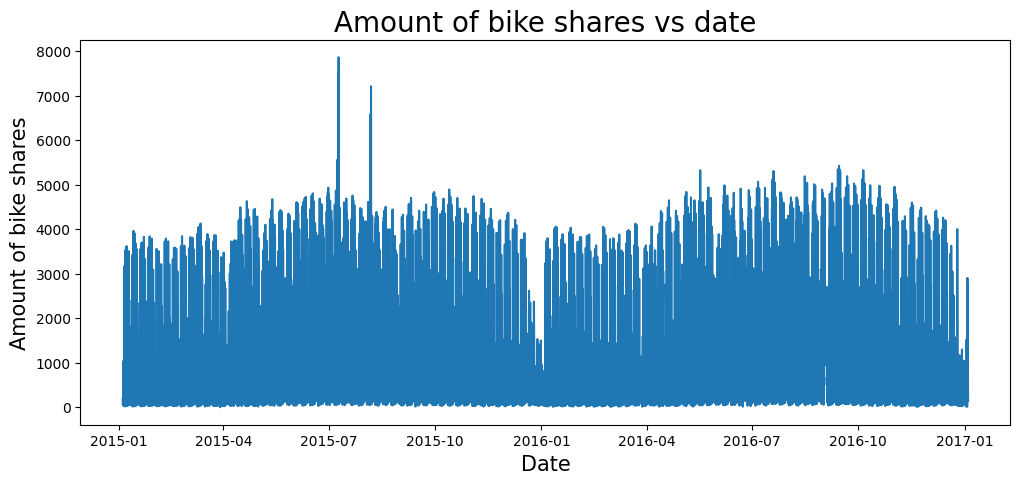

In [49]:
plt.figure(figsize=(12, 5))
ax = sns.lineplot(x=df.index, y=df.cnt, data=df)
ax.set_title("Amount of bike shares vs date", fontsize=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel('Amount of bike shares', fontsize=15)
plt.show()

### Amount of bike shares per month


Resample timeseries, for plotting timeseries month frequency

In [50]:
df_by_month = df[["cnt"]].resample("M").sum()
df_by_month.head()


cnt
timestamp         
2015-01-31  546639
2015-02-28  543594
2015-03-31  695934
2015-04-30  831582
2015-05-31  895413

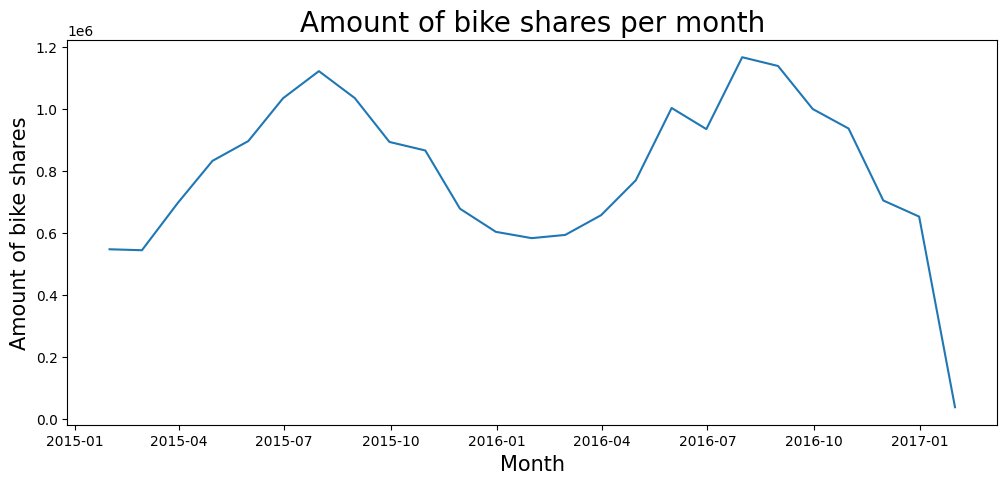

In [51]:
plt.figure(figsize=(12, 5))
ax = sns.lineplot(data=df_by_month,x=df_by_month.index,y=df_by_month.cnt)
ax.set_title("Amount of bike shares per month", fontsize=20)
ax.set_xlabel("Month", fontsize=15)
ax.set_ylabel('Amount of bike shares', fontsize=15)
plt.show()

### Amount of bike shares per day

C:\Users\Federico\AppData\Local\Temp\ipykernel_17056\2696443410.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_by_week = df.resample("D").sum()


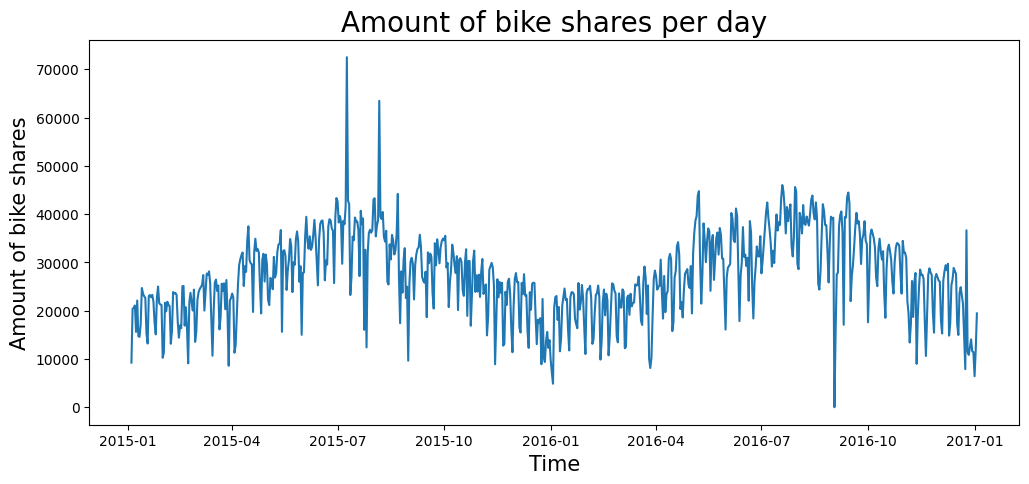

In [52]:
df_by_week = df.resample("D").sum()
plt.figure(figsize=(12, 5))
ax = sns.lineplot(data=df_by_week,x=df_by_week.index,y=df_by_week.cnt)
ax.set_title("Amount of bike shares per day", fontsize=20)
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel('Amount of bike shares', fontsize=15)
plt.show()

We observe that the number of rentals decreases during the winter months and increases during the summer months. Could it be a temperature and/or weather related phenomenon? We will investigate this aspect later.

### Amount of bike shares per season

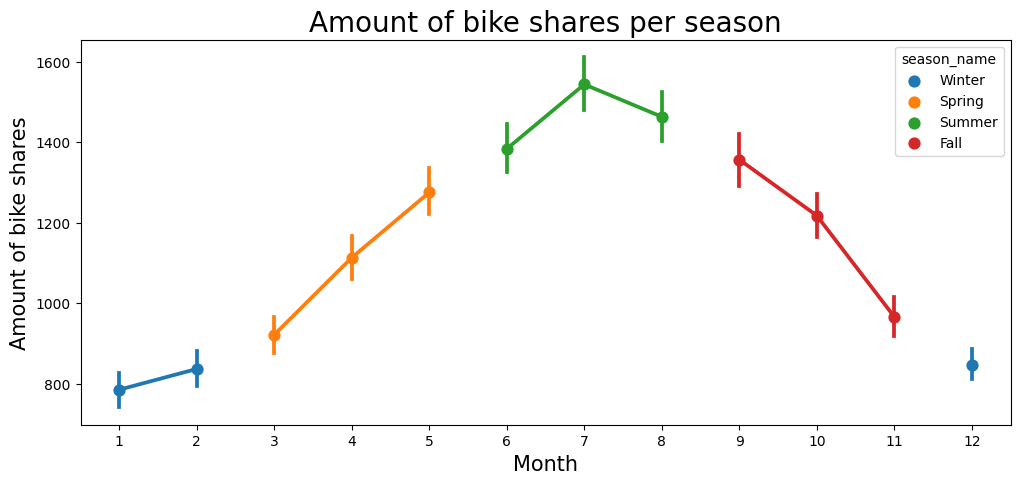

In [53]:
plt.figure(figsize=(12, 5))
ax = sns.pointplot(data=df,hue=df.season_name,y=df.cnt,x=df.month)
ax.set_title("Amount of bike shares per season", fontsize=20)
ax.set_xlabel("Month", fontsize=15)
ax.set_ylabel('Amount of bike shares', fontsize=15)
plt.show()

We observe how the number of rentals varies during the seasons; the number of rentals is higher during the summer and lower during the winter

### Amount of bike shares in a week

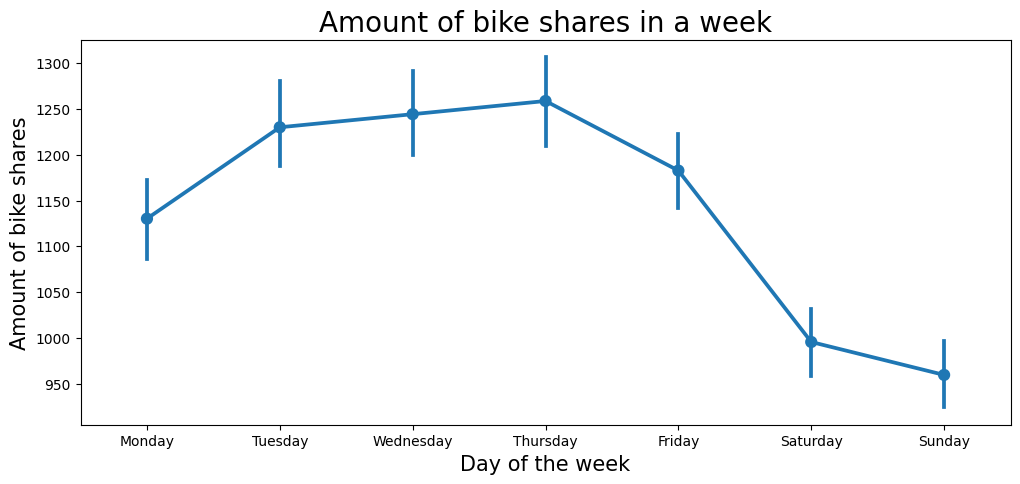

In [54]:
#df = df.sort_values(by=['day_of_week'])
plt.figure(figsize=(12, 5))
ax = sns.pointplot(x="day_name", y='cnt',data=df.sort_values(by=['day_of_week']))
ax.set_title("Amount of bike shares in a week", fontsize=20)
ax.set_xlabel("Day of the week", fontsize=15)
ax.set_ylabel('Amount of bike shares', fontsize=15)
plt.show()

The graph shows that the average number of rentals decreases over the weekend. Could this phenomenon be linked to the use that citizens make of bicycles? An higher average value outside the weekend suggests that the bikes could be used to commute to work!

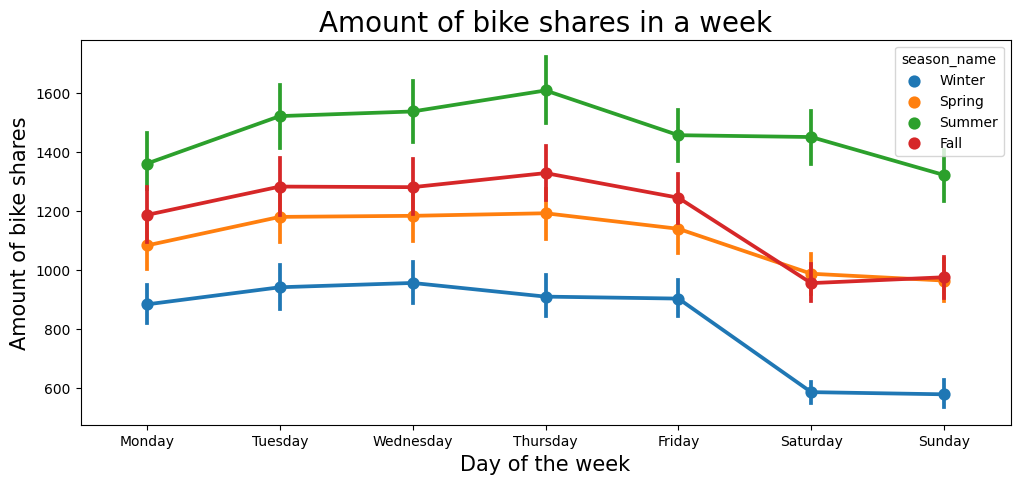

In [55]:
plt.figure(figsize=(12, 5))
ax = sns.pointplot(x="day_name", y='cnt',data=df.sort_values(by=['day_of_week']), hue=df.season_name)
ax.set_title("Amount of bike shares in a week", fontsize=20)
ax.set_xlabel("Day of the week", fontsize=15)
ax.set_ylabel('Amount of bike shares', fontsize=15)
plt.show()

Observing the average number of weekly rentals for the different seasons, the trend described above is confirmed; there is a drop in rentals during the weeekend especially in the colder seasons.

### Amount of bike shares in a day

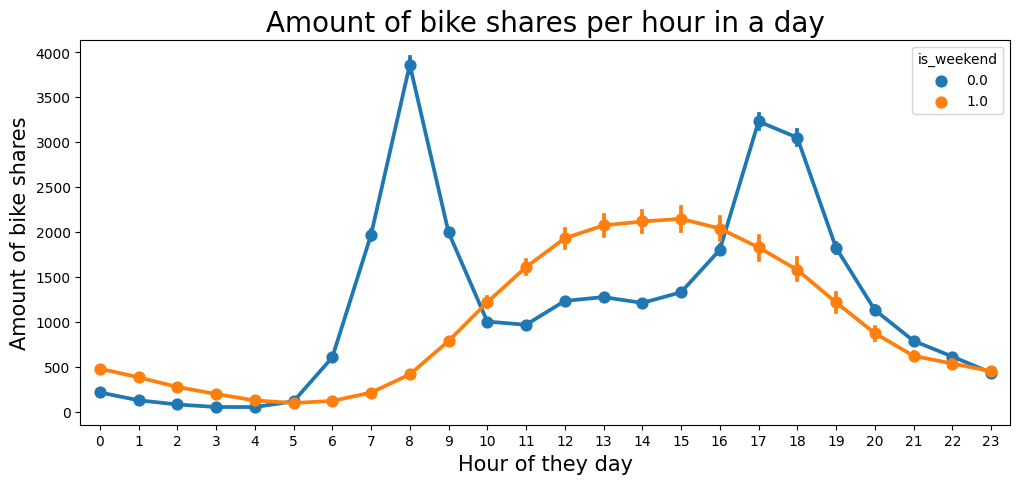

In [56]:
plt.figure(figsize=(12, 5))
ax = sns.pointplot(x='hour', y='cnt',hue='is_weekend',data=df)
ax.set_title("Amount of bike shares per hour in a day", fontsize=20)
ax.set_xlabel("Hour of they day", fontsize=15)
ax.set_ylabel('Amount of bike shares', fontsize=15)
plt.show()

In the graph above we show the trend of the average number of rentals during the hours of the day in case of workday and weekend day.

We observe that during the working days there are two peaks at the times of entry and exit from the offices. During the weekend there is a smoother curve with a lower rental maximum reached during the early afternoon hours.


### Amount of bike shares in holiday vs weekday

                    cnt
is_holiday             
0.0         1151.525191
1.0          769.526042


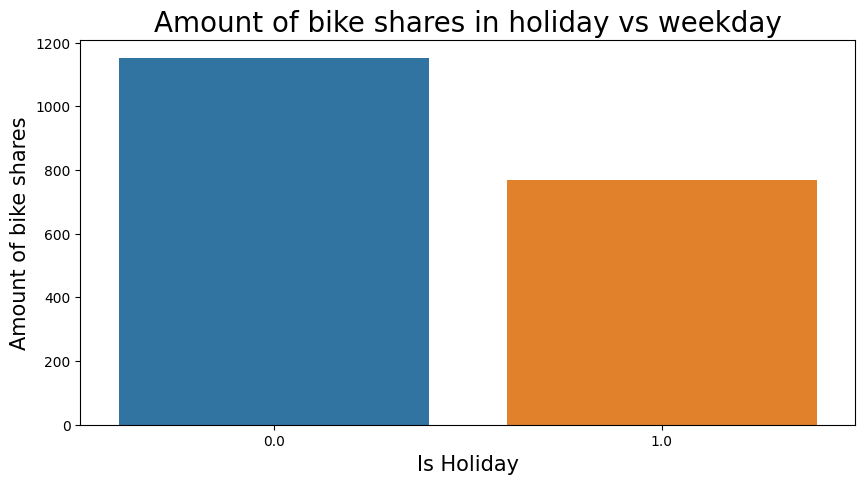

In [57]:
df_by_holiday = df[["is_holiday", "cnt"]].groupby("is_holiday").mean()
print(df_by_holiday)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=df_by_holiday.index, y='cnt', data=df_by_holiday)
ax.set_title("Amount of bike shares in holiday vs weekday", fontsize=20)
ax.set_xlabel("Is Holiday", fontsize=15)
ax.set_ylabel('Amount of bike shares', fontsize=15)
plt.show()


It can be concluded that's there a distinct difference in shares when it's not a working day. We will take this aspect into account in the training part of the predictive model.

### Amount of bike shares related to weather conditions

We want to investigate the relationship between the number of rentals and the weather conditions: real and perceived temperature, humidity and wind.

In [58]:
df.reset_index(inplace=True)
df.head()

timestamp  cnt   t1   t2    hum  wind_speed  weather_code  \
0 2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0           3.0   
1 2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0           1.0   
2 2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0           1.0   
3 2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0           1.0   
4 2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5           1.0   

   is_holiday  is_weekend  season  hour  day_of_month  day_of_week  month  \
0         0.0         1.0     3.0     0             4            6      1   
1         0.0         1.0     3.0     1             4            6      1   
2         0.0         1.0     3.0     2             4            6      1   
3         0.0         1.0     3.0     3             4            6      1   
4         0.0         1.0     3.0     4             4            6      1   

   year day_name season_name  
0  2015   Sunday      Winter  
1  2015   Sunday      Winter  
2  2015   Sunday      Winter  
3  2015   Sunday      Winter  
4  2015   Sunday      Winter

#### Amount of bike shares related to temperature

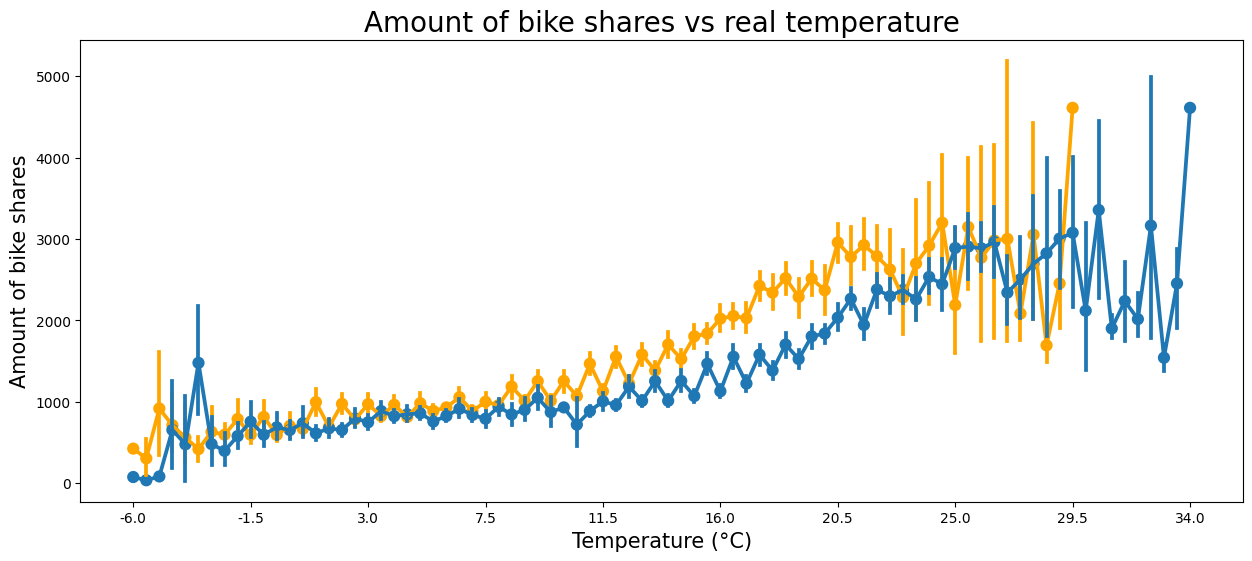

In [59]:
plt.figure(figsize=(15,6))

ax = sns.pointplot(x='t1', y='cnt', data=df, color="orange")
ax = sns.pointplot(x='t2', y='cnt', data=df)
ax.set_title("Amount of bike shares vs real temperature", fontsize=20)
ax.set_xlabel("Temperature (°C)", fontsize=15)
ax.set_ylabel('Amount of bike shares', fontsize=15)
plt.locator_params(axis='x', nbins=10)


In the graph we show how the number of rentals varies with the real (orange line) and perceived (blue line) temperature.
In both cases we observe a linear growth of the counts as a function of temperature.

This shows that there is a positive correlation between temperature and the amount of bike shares; this confirms the higher number of rentals observed during the summer months.

Temperature and counts correlation coefficient:


0.3887984512547308

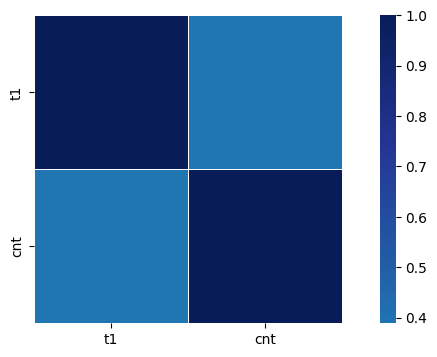

In [60]:
#heatmap
plt.figure(figsize=(10,4))
sns.heatmap(df[["t1", "cnt"]].corr(),cmap="YlGnBu",square=True,linewidths=.5,center=0)
print("Temperature and counts correlation coefficient:")
df["t1"].corr(df["cnt"], method = "pearson")

#### Amount of bike shares related to the humidity

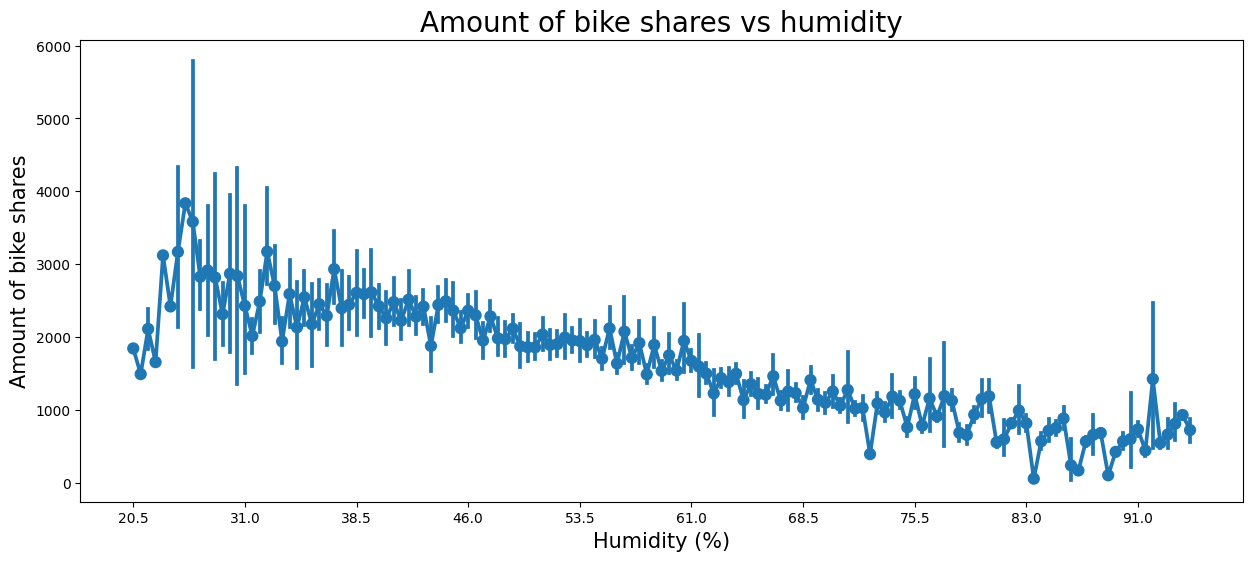

In [61]:
plt.figure(figsize=(15,6))

ax = sns.pointplot(x='hum', y='cnt',data=df)
ax.set_title("Amount of bike shares vs humidity", fontsize=20)
ax.set_xlabel("Humidity (%)", fontsize=15)
ax.set_ylabel('Amount of bike shares', fontsize=15)
plt.locator_params(axis='x', nbins=10)
plt.show()

This shows that there is a negative correlation between humidity and the amount of bike shares: an increase in humidity results in a decrease of the bikes shared.

Humidity and counts correlation coefficient:


-0.4629009648427376

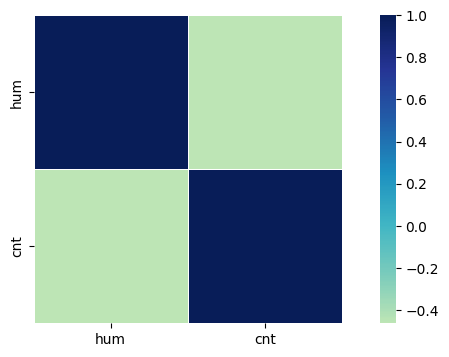

In [62]:
#heatmap
plt.figure(figsize=(10,4))
sns.heatmap(df[["hum", "cnt"]].corr(),cmap="YlGnBu",square=True,linewidths=.5,center=0)
print("Humidity and counts correlation coefficient:")
df["hum"].corr(df["cnt"], method = "pearson")


#### Temperature-Humidity correlation

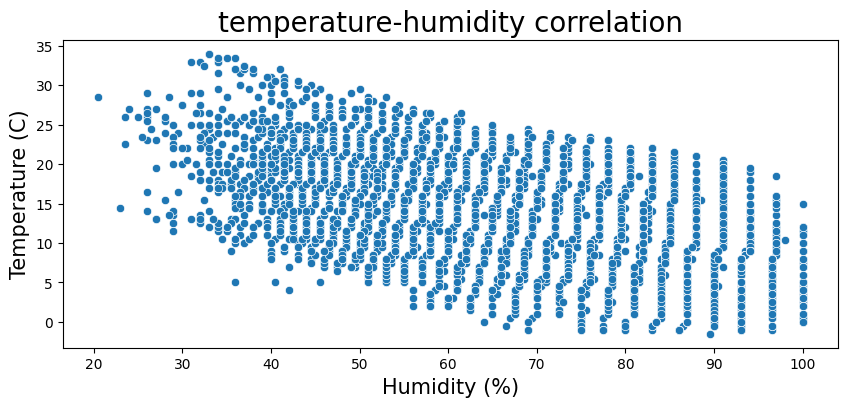

In [63]:
plt.figure(figsize=(10,4))

ax = sns.scatterplot(x='hum', y='t1',data=df)
ax.set_title("temperature-humidity correlation", fontsize=20)
ax.set_xlabel("Humidity (%)", fontsize=15)
ax.set_ylabel('Temperature (C)', fontsize=15)
plt.locator_params(axis='x', nbins=10)
plt.show()

Temperature and humidity have a weak negative correlation:


<AxesSubplot:>

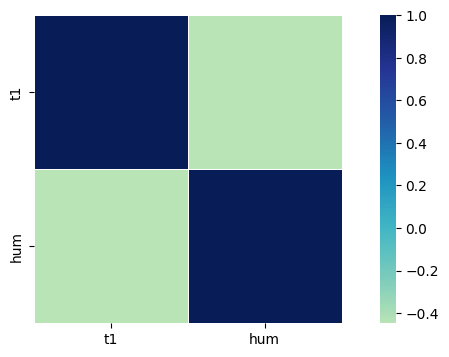

In [64]:
print("Temperature and humidity have a weak negative correlation:")
df["t1"].corr(df["hum"], method = "pearson")
plt.figure(figsize=(10,4))
sns.heatmap(df[["t1", "hum"]].corr(),cmap="YlGnBu",square=True,linewidths=.5,center=0)

#### Amount of bike shares related to the windspeed

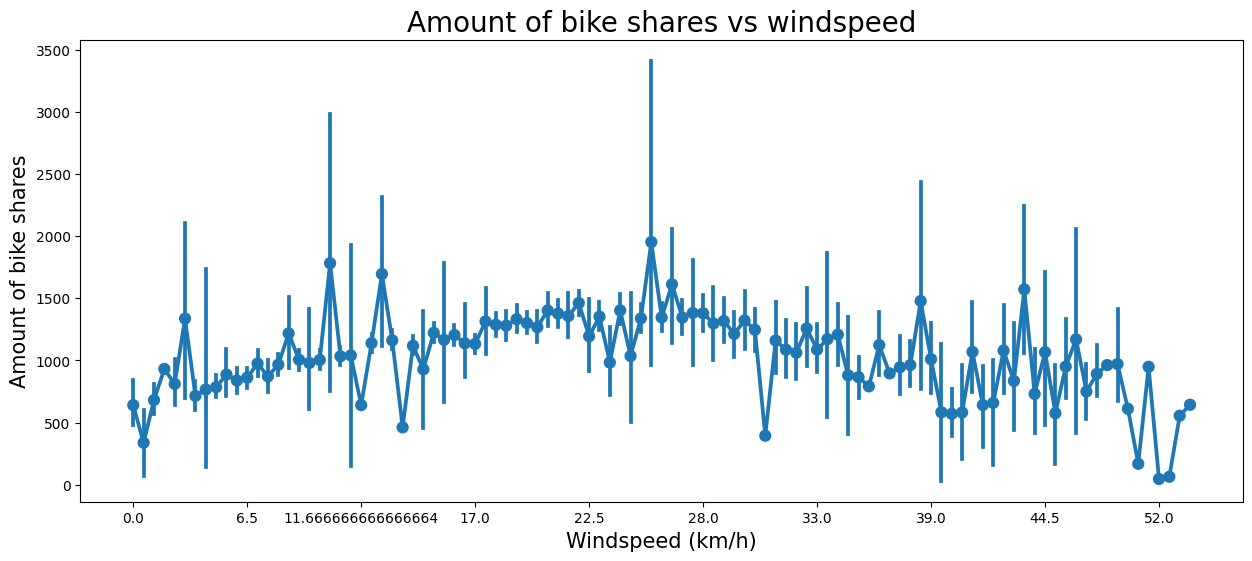

wind speed and bike shares correlation coefficient:


0.14547097164888462

In [65]:
plt.figure(figsize=(15,6))

ax = sns.pointplot(x='wind_speed', y='cnt',data=df)
ax.set_title("Amount of bike shares vs windspeed", fontsize=20)
ax.set_xlabel("Windspeed (km/h)", fontsize=15)
ax.set_ylabel('Amount of bike shares', fontsize=15)
plt.locator_params(axis='x', nbins=10)
plt.show()

print("wind speed and bike shares correlation coefficient:")
df["t1"].corr(df["wind_speed"], method = "pearson")

We observe a very low positive correlation between rentals and wind speed; it leads us to conclude that the wind speed does not have a great predictive power for the number of rentals.

#### Amount of bike shares related to the weather 

In [66]:
# multiple conditions
conditions = [
    (df['weather_code']==1),
    (df['weather_code']==2),
    (df['weather_code']==3),
    (df['weather_code']==4),
    (df['weather_code']==7),
    (df['weather_code']==10),
    (df['weather_code']==26),
    (df['weather_code']==94),
]

values = ['Clear', 'Few clouds ', 'Broken clouds', 'Cloudy', 'Rain', 'Thunderstorm', 'Snowfall', 'Freezing Fog']


df['weather_name'] = np.select(conditions, values) #esegue una select 
df.head()


timestamp  cnt   t1   t2    hum  wind_speed  weather_code  \
0 2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0           3.0   
1 2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0           1.0   
2 2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0           1.0   
3 2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0           1.0   
4 2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5           1.0   

   is_holiday  is_weekend  season  hour  day_of_month  day_of_week  month  \
0         0.0         1.0     3.0     0             4            6      1   
1         0.0         1.0     3.0     1             4            6      1   
2         0.0         1.0     3.0     2             4            6      1   
3         0.0         1.0     3.0     3             4            6      1   
4         0.0         1.0     3.0     4             4            6      1   

   year day_name season_name   weather_name  
0  2015   Sunday      Winter  Broken clouds  
1  2015   Sunday      Winter          Clear  
2  2015   Sunday      Winter          Clear  
3  2015   Sunday      Winter          Clear  
4  2015   Sunday      Winter          Clear

In [67]:
df_by_weather = df.groupby(['weather_name']).agg(cnt=('cnt', 'mean'))
df_by_weather.reset_index(inplace=True)
df_by_weather.sort_values("cnt", inplace=True, ascending=False)
df_by_weather


weather_name          cnt
3    Few clouds   1496.177491
0  Broken clouds  1195.124472
1          Clear  1162.088943
4           Rain   712.966371
2         Cloudy   635.230874
6   Thunderstorm   583.428571
5       Snowfall   250.850000

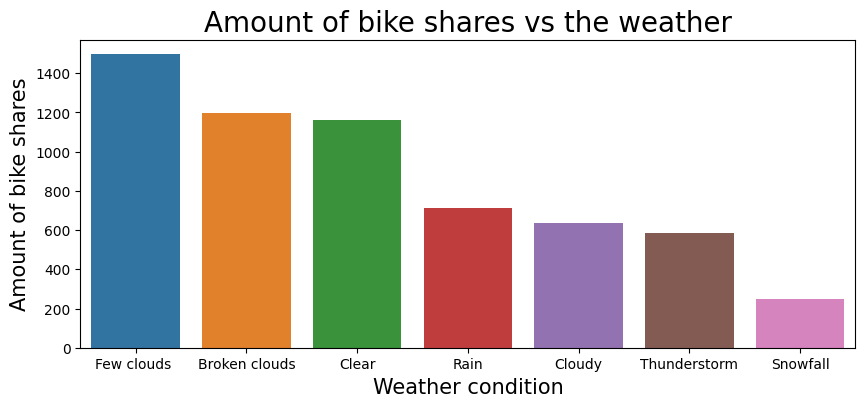

In [68]:
plt.figure(figsize=(10,4))
ax = sns.barplot(data=df_by_weather, x ="weather_name", y="cnt")
ax.set_title("Amount of bike shares vs the weather", fontsize=20)
ax.set_xlabel("Weather condition", fontsize=15)
ax.set_ylabel('Amount of bike shares', fontsize=15)
plt.show()

We observe that the number of rentals decreases with worsening weather conditions.

### Feature correlations
We conclude the Exploratory Data Analysis with an overview of all feature correlations.

C:\Users\Federico\AppData\Local\Temp\ipykernel_17056\3431462200.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),cmap="YlGnBu",square=True,linewidths=.5,center=0)


<AxesSubplot:>

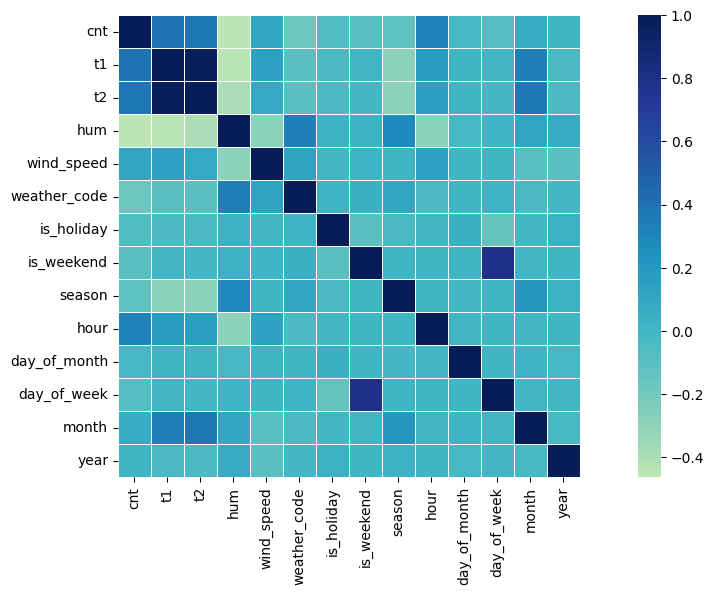

In [69]:
plt.figure(figsize=(15,6))
sns.heatmap(df.corr(),cmap="YlGnBu",square=True,linewidths=.5,center=0)

From the graph we can observe the correlation between the different quantities. We emphasize what we have already seen previously; there is a correlation between the number of rentals, temperature and humidity.

# Bike shares prediction with Prophet


Prophet Forecasting Model is an Additive Regressive Model [[1]](https://medium.com/analytics-vidhya/how-does-prophet-work-44addaab6148): it is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. [[2]](https://facebook.github.io/prophet/) 

This model was introduced by Facebook (S. J. Taylor & Letham, 2018), originally for forecasting daily data with weekly and yearly seasonality, plus holiday effects. It was later extended to cover more types of seasonal data. [[3]](https://otexts.com/fpp3/prophet.html)


<p align="center">   <img src="./1_Oe2mGHiiwDMmRcBlbvS39Q.png"> </p>

where: 
- $g(t)$ describes a piecewise-linear trend (or “growth term”), 
- $s(t)$ describes the various seasonal patterns, 
- $h(t)$ captures the holiday effects,
- $\epsilon_t$ is a white noise error term.


The seasonality component $ s(t) $ provides flexibility (Weekly, Yearly, daily seasonality change components) to the model. Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. Seasonality is estimated using partial Fourier Sum. The Fourier order determines how quickly the seasonality can change (Default order for yearly seasonality is 10, for weekly seasonality order is 3). 
Increasing this Fourier order allows the seasonality to fit faster-changing cycles ( We need to be very careful while setting this parameter as it can lead to overfitting).
We can use conditional seasonality also apart from the default ones (NB The default weekly seasonality assumes the pattern of weekly seasonality is the same throughout the year).
Holiday effects are added as simple dummy variables. The model is estimated using a Bayesian approach to allow for automatic selection of the changepoints and other model characteristics.


### Univariate Prophet
We we'll try to predict both the daily and hourly sales. 

##### Prepare dataset for prediction
In order to train the model it is necessary to prepare the dataset as required by the Prophet library; the dataset must be composed of two columns  `ds`  and  `y`  containing respectively our `timestamp` column in datetime format and `cnt` column.


In [70]:
# loading dataset
data = pd.read_csv("./london_merged.csv")
data["timestamp"] = pd.to_datetime(data["timestamp"])

# create a copy of dataset including only timestamp and count columns
mydata = data[['timestamp', 'cnt']].copy()
mydata["timestamp"] = pd.to_datetime(mydata["timestamp"])
mydata = mydata.set_index("timestamp")
mydata.head()


cnt
timestamp               
2015-01-04 00:00:00  182
2015-01-04 01:00:00  138
2015-01-04 02:00:00  134
2015-01-04 03:00:00   72
2015-01-04 04:00:00   47

We create two dataframes, `daydata`,` hourdata` containing respectively the aggregate data by day and the maximum detail data (by hours).

In [71]:
# Daily resampling
daydata = mydata.resample("D").sum()
daydata['timestamp'] = daydata.index
daydata.index = range(0,len(daydata['cnt'].to_numpy()))
daydata.head()

cnt  timestamp
0   9234 2015-01-04
1  20372 2015-01-05
2  20613 2015-01-06
3  21064 2015-01-07
4  15601 2015-01-08

In [72]:
# No resampling for hourly prediction
hourdata = mydata
hourdata['timestamp'] = hourdata.index
hourdata.index = range(0,len(hourdata['cnt'].to_numpy()))
hourdata.head()

cnt           timestamp
0  182 2015-01-04 00:00:00
1  138 2015-01-04 01:00:00
2  134 2015-01-04 02:00:00
3   72 2015-01-04 03:00:00
4   47 2015-01-04 04:00:00

We apply the specific transformations required by the Prophet library; let's rename the columns as follows.

In [73]:
daydf = daydata[['timestamp','cnt']].copy()
daydf.columns = ['ds','y']

hourdf = hourdata[['timestamp','cnt']].copy()
hourdf.columns = ['ds', 'y']

# Daily model

In [74]:
from prophet import Prophet

# instantiate the daily model
daymodel = Prophet()

# Fit the model with train set
daymodel.fit(daydf) 

# Simulate the trend using the model
dayfuture = daymodel.make_future_dataframe(periods=365)

# Predict using the prophet model.
daypred = daymodel.predict(dayfuture)


18:59:18 - cmdstanpy - INFO - Chain [1] start processing
18:59:18 - cmdstanpy - INFO - Chain [1] done processing


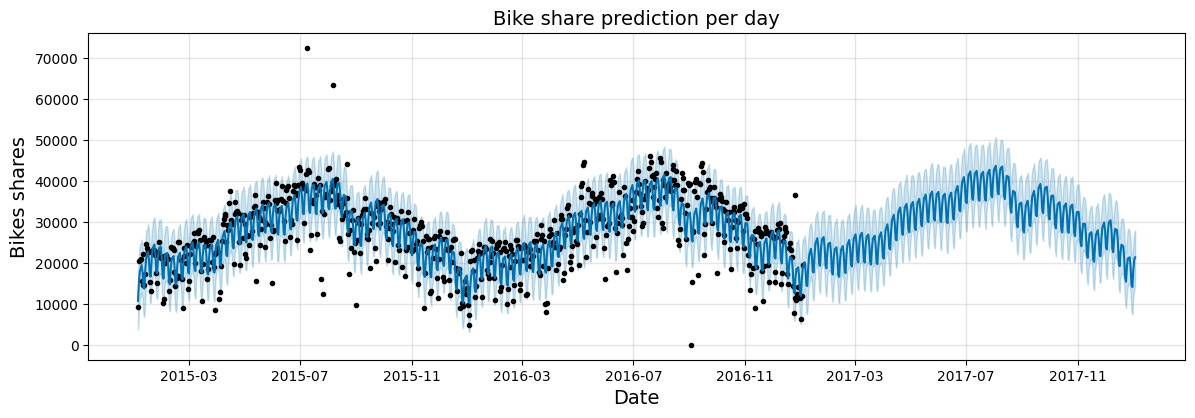

In [75]:
# Plot the day forecast
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(12)

daymodel.plot(daypred, ax=ax)
ax.set_title('Bike share prediction per day', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Bikes shares', fontsize=14)
plt.show()

Unfortunately since we needed to use all hour training data it's not possible to evaluate the models we created. We'll have to evaluate them visually instead.

The daily-model visually seems to correctly predict the trend by highlighting a clear annual seasonality: as expected, an increase in the predicted rentals during the summer period and a decrease during the winter period can be observed.

We analyze the individual components of the model

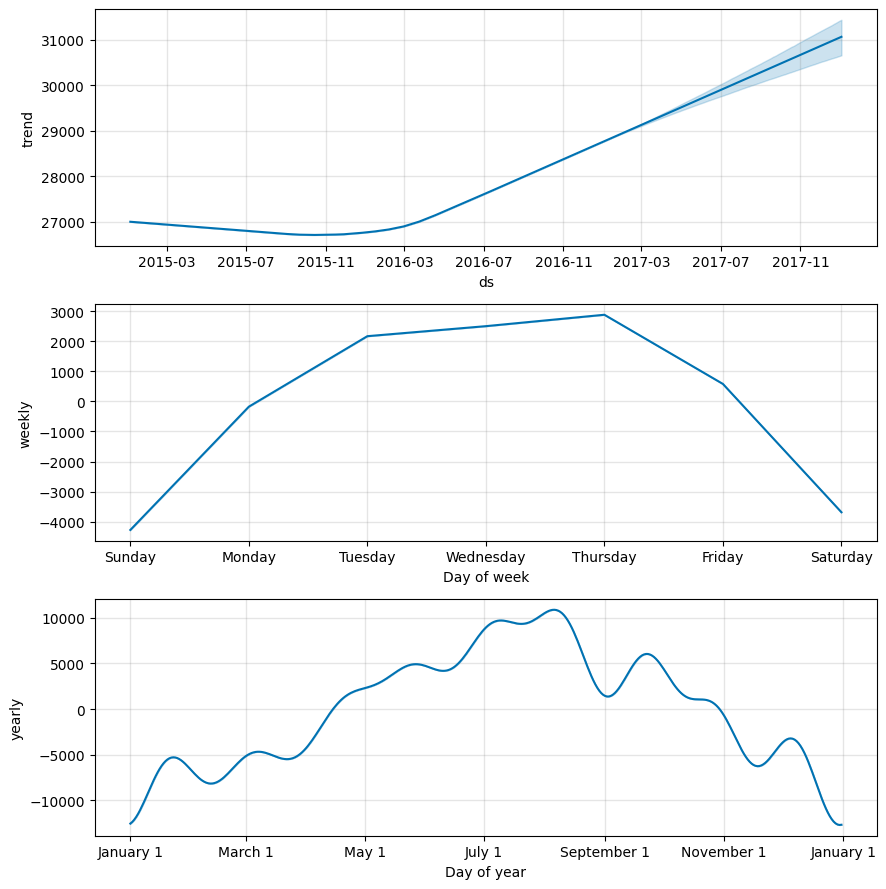

In [76]:
fig = daymodel.plot_components(daypred)

- trend: shows the presence of a positive trend over the years with a growing number of rentals.

- weekly seasonality: the trend observed during the exploratory analysis is confirmed; the number of counts is lower during the weekend than the rest of the week

- yearly seasonality: the trend observed during the exploratory analysis is confirmed; as in the summer there is a greater number of rentals than in the winter

# Hourly model
We are going to repeat the steps performed in the daily case, taking the dataset with greater detail (by hour). Compared to the daily case, we are going to perform a tuning of some parameters (daily-seasonality and holiday) to take into consideration the phenomena observed during the exploratory analysis (different trend of the counts during the weekend and a lower number of rentals during the holidays)

#### Preparing dataset for daily-seasonality tuning

In [77]:
import datetime

# define function to check if a day is on weekend or not 
def is_weekend_day(ds):
    """check if a day is on weekend (True) or not (False)"""

    weekno = datetime.datetime.weekday(ds)
    if weekno >= 5:
        return True
    else:
        return False


hourdf['on_weekend'] = hourdf['ds'].apply(is_weekend_day)
hourdf['off_weekend'] = ~hourdf['ds'].apply(is_weekend_day)
hourdf.head()


ds    y  on_weekend  off_weekend
0 2015-01-04 00:00:00  182        True        False
1 2015-01-04 01:00:00  138        True        False
2 2015-01-04 02:00:00  134        True        False
3 2015-01-04 03:00:00   72        True        False
4 2015-01-04 04:00:00   47        True        False

#### Preparing dataset for holiday contribution

In [78]:
data_hol = data[data["is_holiday"]==1.0]
list_holiday = [hol["timestamp"] for _, hol in data_hol.iterrows()]

Holiday_dataframe = pd.DataFrame(
    {
        'holiday': 'generic_holiday',
        'ds': pd.to_datetime(list_holiday),
    })

Holiday_dataframe.head()

holiday                  ds
0  generic_holiday 2015-04-03 00:00:00
1  generic_holiday 2015-04-03 01:00:00
2  generic_holiday 2015-04-03 02:00:00
3  generic_holiday 2015-04-03 03:00:00
4  generic_holiday 2015-04-03 04:00:00

#### Fit the model and predict future bike-shares

In [79]:
# instantiate the Prophet model adding custom seasonalities
m = Prophet(daily_seasonality=False, holidays=Holiday_dataframe)
m.add_seasonality(name='daily_on_weekend', period=1, fourier_order=3, condition_name='on_weekend')
m.add_seasonality(name='daily_off_weekend', period=1, fourier_order=3, condition_name='off_weekend')

# fitting the model
m.fit(hourdf)

# Simulate the trend using the model.
future = m.make_future_dataframe(periods=365, freq="H")
future['on_weekend'] = future['ds'].apply(is_weekend_day)
future['off_weekend'] = ~future['ds'].apply(is_weekend_day)

# Predict using the prophet model.
forecast = m.predict(future)
forecast.head(3)

18:59:19 - cmdstanpy - INFO - Chain [1] start processing
18:59:22 - cmdstanpy - INFO - Chain [1] done processing


ds        trend  yhat_lower  yhat_upper  trend_lower  \
0 2015-01-04 00:00:00  1130.543100 -870.586640  691.435337  1130.543100   
1 2015-01-04 01:00:00  1130.558112 -902.279846  647.916982  1130.558112   
2 2015-01-04 02:00:00  1130.573125 -889.783663  572.694453  1130.573125   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  1130.543100    -1226.113067          -1226.113067          -1226.113067   
1  1130.558112    -1253.629390          -1253.629390          -1253.629390   
2  1130.573125    -1308.572068          -1308.572068          -1308.572068   

   daily_off_weekend  ...      weekly  weekly_lower  weekly_upper      yearly  \
0                0.0  ... -187.929263   -187.929263   -187.929263 -462.677764   
1                0.0  ... -188.141691   -188.141691   -188.141691 -462.377232   
2                0.0  ... -187.948477   -187.948477   -187.948477 -462.072977   

   yearly_lower  yearly_upper  multiplicative_terms  \
0   -462.677764   -462.677764                   0.0   
1   -462.377232   -462.377232                   0.0   
2   -462.072977   -462.072977                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  -95.569967  
1                         0.0                         0.0 -123.071277  
2                         0.0                         0.0 -177.998943  

[3 rows x 31 columns]

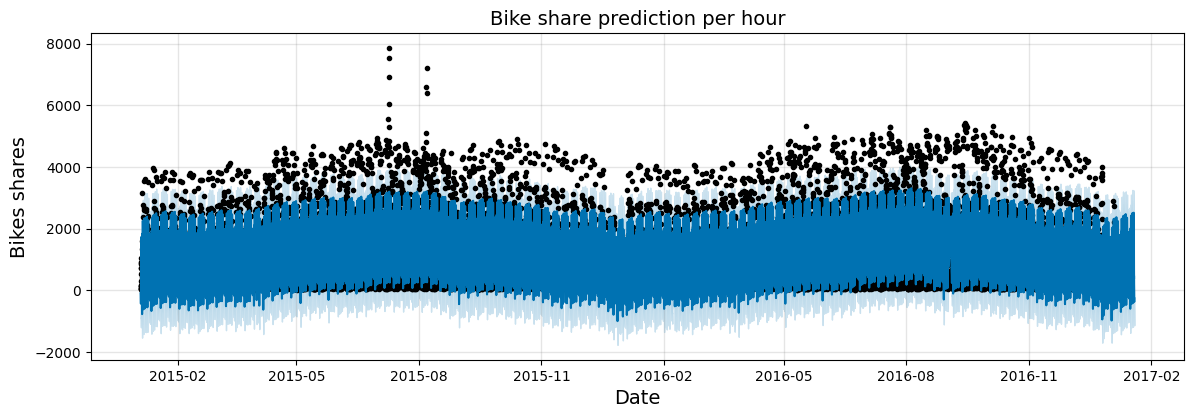

In [80]:
# Plot hourly forecast
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(12)

m.plot(forecast, ax=ax)

ax.set_title('Bike share prediction per hour', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Bikes shares', fontsize=14)

plt.show()

#### Model components analysis

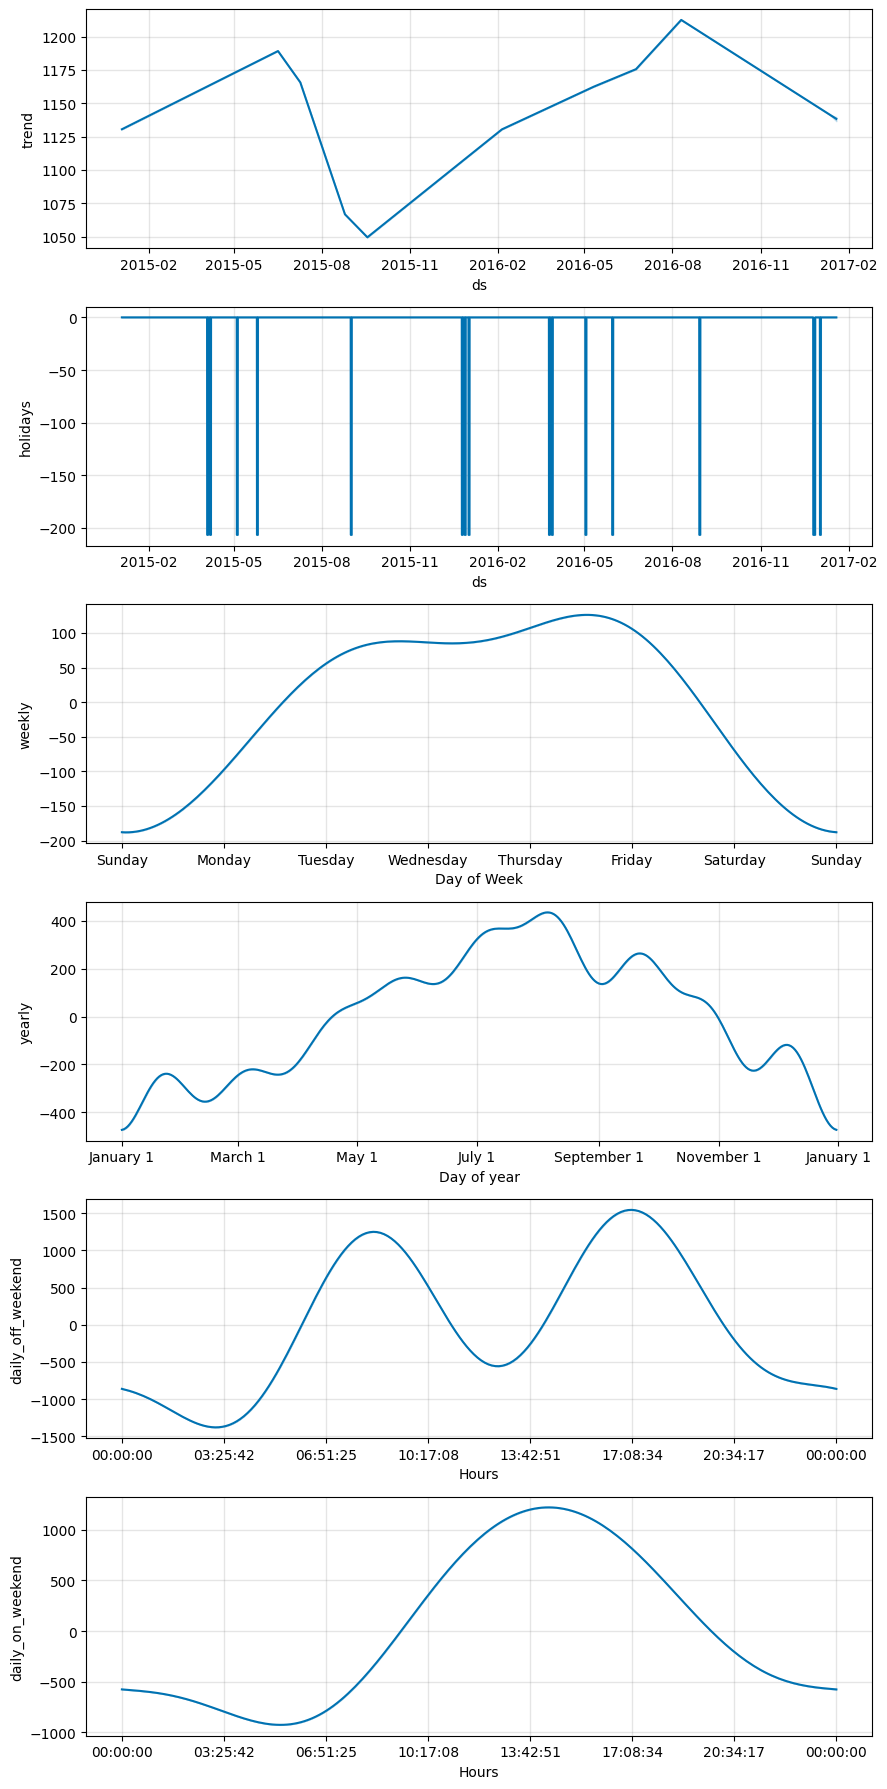

In [81]:
fig = m.plot_components(forecast)

- **trend**: the model seems to be able to better capture the annual fluctuations in the trend.

- **weekly** seasonality: the trend observed during the exploratory analysis is confirmed; the number of counts was lower during the weekend than the rest of the week

- **yearly** seasonality: the trend observed during the exploratory analysis is confirmed; in the summer there is a greater number of rentals than in the winter

- **holidays**: the addition of holidays seems to lead to a negative contribution in correspondence with the holidays, in line with what has been observed from the analyzes where we found a decrease in the number of rentals on these occasions compared to weekdays.

- **daily_on_weekend**: this component of the model wants to take into account the rental trend during the weekend; there is a positive contribution to the count of rentals in the early afternoon, in line with what was observed during the exploratory analyzes.  

- **daily_off_weekend**: this component of the model wants to take into account the trend of rentals during workdays; there is a positive contribution to the counting of rentals in two time slots corresponding to entry and exit from the offices in line with what was observed during the exploratory analyzes.

# Conclusions

By a visual analysis it seems that the model is able to predict quite well the trend of the number of bike rentals in London, managing to capture the seasonality that emerged even during the data analysis phase.

In order to be properly trained, the model requires two complete annuities of data and our dataset consists of exactly two annuities.
For this we had to use all the data at our disposal to train the model which did not allow us to perform a validation on a test dataset.

However, both predictions look promising.